In [2]:
#!pip install numpy==1.23.5
#!pip install pandas==1.5.3
#!pip install matplotlib==3.7.1
#!pip install student-mixture==0.1.14
#!pip install scikit-learn==0.22.2
#!pip install scipy==1.10.1
#!pip install ipykernel
#!pip install openpyxl
#!pip install tqdm
#!pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lib.module.movidas import *
import student_mixture as sm
from tqdm import tqdm
import sklearn as sl
import importlib

In [4]:
np.random.seed(0)

In [5]:
### Import stock price data for model calibration
freq = 'B'
assets = ['JPM UN Equity', 'PFE UN Equity', 'XOM UN Equity']
nb_asset = len(assets)

df = get_df(assets)

X = df.values

In [6]:
### Fit Student-t mixture (2 components) to chosen stock returns

SM_model = fit_student_mixture(X)


In [7]:
### Print model parameters 
print("==== Number of assets ====")
print(nb_asset)
print("==== Weights (probability) parameters ====")
print(SM_model.weights_)
print("==== Degree of freedom parameters ====")
print(SM_model.dofs_)
print("==== Location parameters ====")
print(SM_model.locations_)
print("==== Scale parameters ====")
print(SM_model.scales_)

==== Number of assets ====
3
==== Weights (probability) parameters ====
[0.7 0.3]
==== Degree of freedom parameters ====
[3.4 2.6]
==== Location parameters ====
[[ 0.0001  0.0002 -0.0003]
 [ 0.001   0.0005  0.0002]]
==== Scale parameters ====
[[[9.e-05 3.e-05 5.e-05]
  [3.e-05 9.e-05 3.e-05]
  [5.e-05 3.e-05 1.e-04]]

 [[4.e-04 1.e-04 1.e-04]
  [1.e-04 1.e-04 6.e-05]
  [1.e-04 6.e-05 1.e-04]]]


In [8]:
### Compute the Risk Budgeting portfolio under the above model

# ERC
budgets = np.ones(nb_asset)/nb_asset 
# Expected Shortfall alpha
alpha = .95 

SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

print('==== Target Risk Bugdets ====')
print(np.round(budgets, 4))
print('==== $y^*$ ====')
print(np.round(optim_res.x, 4))

print('==== Risk Budgeting portfolio ($u^*$) ====')
print(np.round(SM_theta, 4))
print('==== VaR of the portfolio ====')
print(np.round(VaR_port, 4))
print('==== Expected Shortfall of the portfolio ====')
print(np.round(ES_port, 4))
print('==== Risk Contributions ====')
print(np.round(risk_contribs, 5))
print('==== Risk Contributions (normalized) ====')
print(np.round(risk_contribs/sum(risk_contribs), 2))

==== Target Risk Bugdets ====
[0.3333 0.3333 0.3333]
==== $y^*$ ====
[ 7.7128 11.761  10.9475]
==== Risk Budgeting portfolio ($u^*$) ====
[0.2535 0.3866 0.3599]
==== VaR of the portfolio ====
0.0193
==== Expected Shortfall of the portfolio ====
0.0329
==== Risk Contributions ====
[0.01096 0.01096 0.01096]
==== Risk Contributions (normalized) ====
[0.33 0.33 0.33]


In [9]:
#Compute the norm_1 of y^*
round(sum(optim_res.x), 4)

30.4212

## Stochastic case 
We will work later with the deterministic case for it's results and figures


Case $\gamma_n = n^{-0.75}$ with $10^6$ samples and 10 epochs

In [51]:
#set the parameters for the first case
n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

In [52]:
exp = 0.75
M = 100 

In [53]:
problem1 = stoch_sol(X, M , n_val, nb_asset, budgets, exp=exp)

100%|██████████| 10/10 [03:40<00:00, 22.04s/it]


In [54]:
problem1.results(SM_theta, real_ES= ES_port, real_VaR = VaR_port)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.2537 0.3865 0.3598]
==== MD Risk Budgeting portfolio wo ====
[ 7.7023 11.7327 10.9231]
==== Expected Shortfall of the portfolio ====
0.0329
==== VaR of the portfolio ====
0.0193
==== xi: VaR ====
0.0192
0.0333


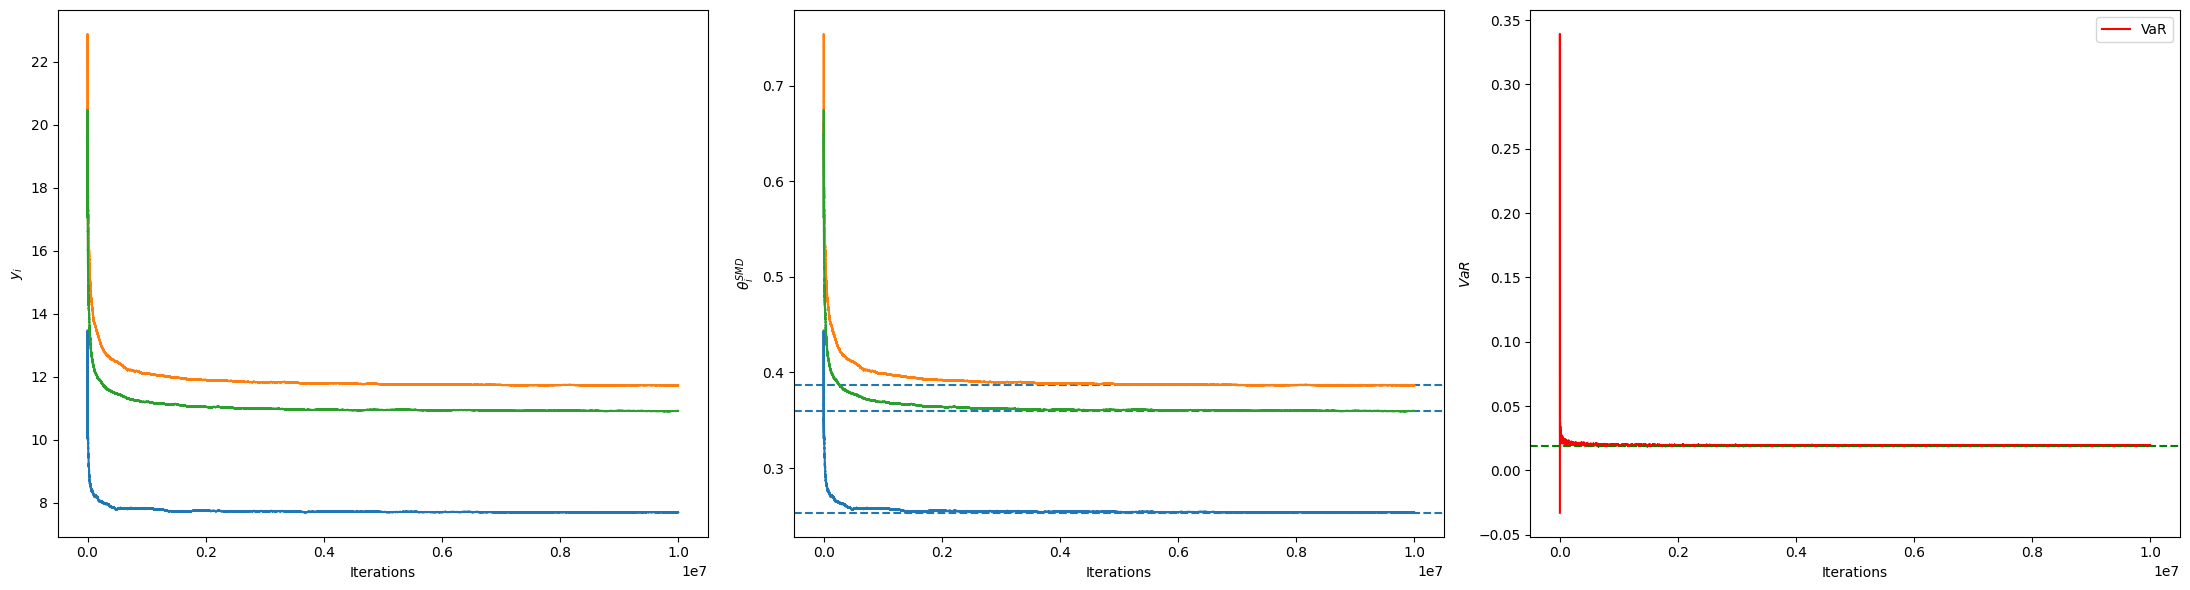

In [55]:
fig, axes= plt.subplots(1,3, figsize=(22,6))
for i in range(problem1.nb_asset):
    axes[0].plot(problem1.ys[i])

axes[0].set_xlabel('Iterations')
axes[0].set_ylabel(r'$y_i$')

for j in range(len(SM_theta)):
    axes[1].axhline(SM_theta[j], linestyle='--')
for i in range(problem1.nb_asset):
    axes[1].plot(problem1.ys[i] / sum(problem1.y), label=f'Component {i+1}')
    
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel(r'$\theta^{SMD}_i$')


axes[2].plot(problem1.xi_final/ sum(problem1.y), label='VaR', color='red')
axes[2].axhline(VaR_port, color='green', linestyle='--')   
axes[2].set_ylabel(r'$VaR$')
axes[2].set_xlabel('Iterations')
axes[2].legend()
plt.tight_layout()
plt.show()

Case for $\gamma_n = n^{-0.55}$, 25.000 samples and 10 epochs


In [56]:
#set the parameters for the first case
n_val= 25000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

In [57]:
exp=0.55
M = 100


In [58]:
problem2 = stoch_sol(X, M , n_val, nb_asset, budgets, exp=exp)

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


In [59]:
problem2.results(SM_theta, real_ES= ES_port, real_VaR = VaR_port)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.2595 0.3893 0.3512]
==== MD Risk Budgeting portfolio wo ====
[ 7.9699 11.9551 10.7878]
==== Expected Shortfall of the portfolio ====
0.0329
==== VaR of the portfolio ====
0.0193
==== xi: VaR ====
0.0209
0.0336


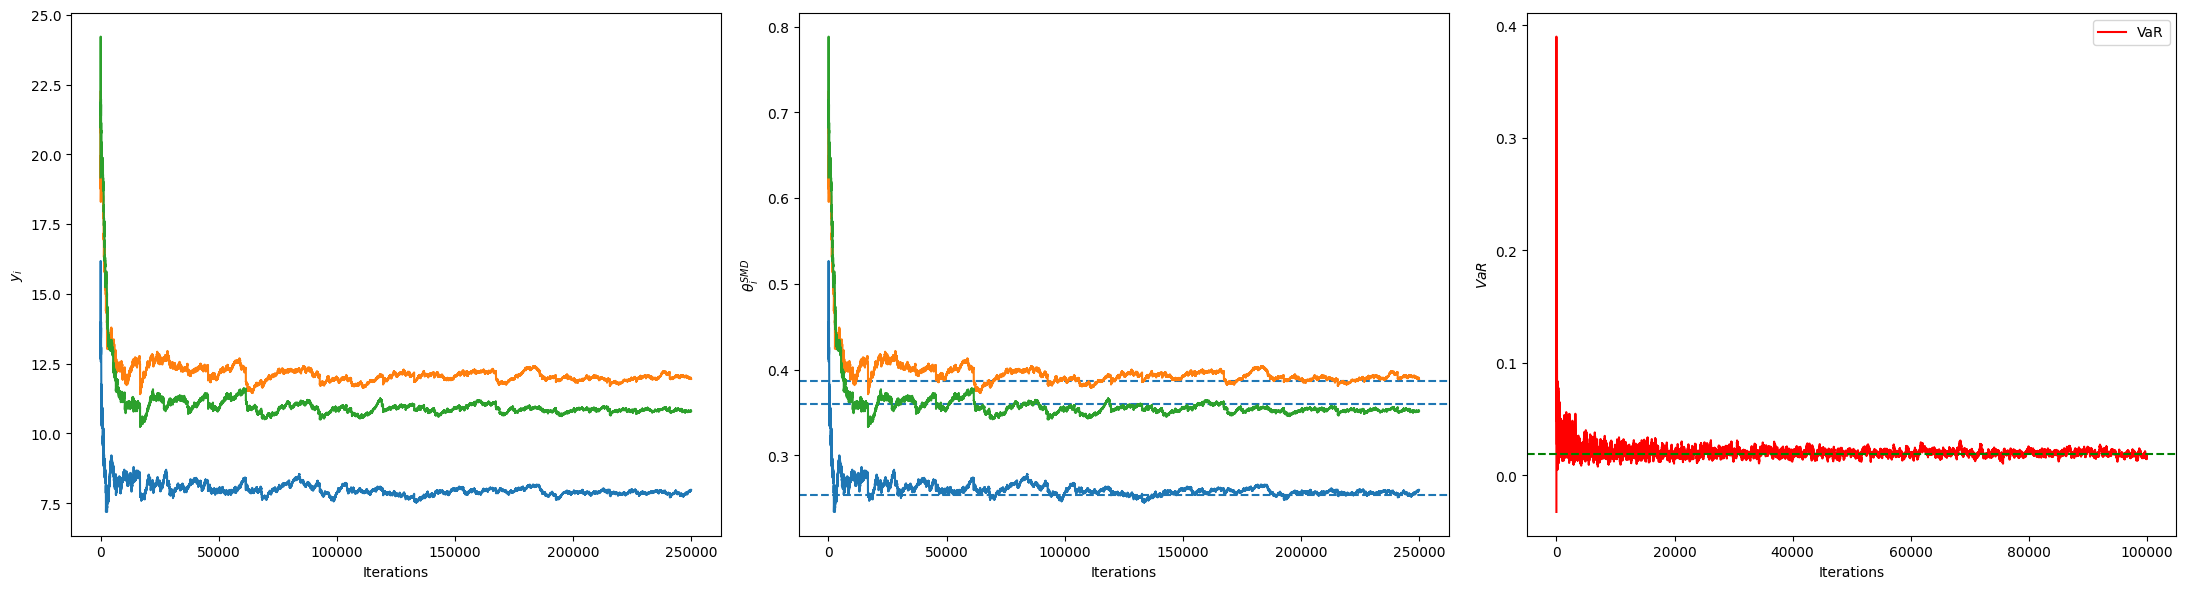

In [60]:
fig, axes= plt.subplots(1,3, figsize=(22,6))
for i in range(problem2.nb_asset):
    axes[0].plot(problem2.ys[i][:1000000])

axes[0].set_xlabel('Iterations')
axes[0].set_ylabel(r'$y_i$')

for j in range(len(SM_theta)):
    axes[1].axhline(SM_theta[j], linestyle='--')
for i in range(problem2.nb_asset):
    axes[1].plot(problem2.ys[i][:1000000] / sum(problem2.y), label=f'Component {i+1}')
    
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel(r'$\theta^{SMD}_i$')


axes[2].plot(problem2.xi_final[:100000]/ sum(problem2.y), label='VaR', color='red')
axes[2].axhline(VaR_port, color='green', linestyle='--')   
axes[2].set_ylabel(r'$VaR$')
axes[2].set_xlabel('Iterations')
axes[2].legend()
plt.tight_layout()
plt.show()

In [78]:
n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

In [79]:
exp=0.75

In [80]:
M=10

In [81]:
problem3 = stoch_sol(X, M , n_val, nb_asset, budgets, exp=exp)

100%|██████████| 10/10 [03:50<00:00, 23.00s/it]


In [82]:
problem3.results(SM_theta, real_ES= ES_port, real_VaR = VaR_port)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.2989 0.3553 0.3458]
==== MD Risk Budgeting portfolio wo ====
[2.9893 3.5528 3.4578]
==== Expected Shortfall of the portfolio ====
0.0329
==== VaR of the portfolio ====
0.0193
==== xi: VaR ====
0.0196
0.0335


In [83]:
M=35

In [84]:
problem4 = stoch_sol(X, M , n_val, nb_asset, budgets, exp=exp)

100%|██████████| 10/10 [03:38<00:00, 21.83s/it]


In [85]:
problem4.results(SM_theta, real_ES= ES_port, real_VaR = VaR_port)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.2541 0.3858 0.36  ]
==== MD Risk Budgeting portfolio wo ====
[ 7.743  11.7556 10.9703]
==== Expected Shortfall of the portfolio ====
0.0329
==== VaR of the portfolio ====
0.0193
==== xi: VaR ====
0.0193
0.0329


In [86]:
M = 1000

In [87]:
problem5 = stoch_sol(X, M , n_val, nb_asset, budgets, exp=exp)

100%|██████████| 10/10 [03:35<00:00, 21.52s/it]


In [88]:
problem5.results(SM_theta, real_ES= ES_port, real_VaR = VaR_port)

==== True Risk Budgeting portfolio ====
[0.2535 0.3866 0.3599]
==== MD Risk Budgeting portfolio ====
[0.254 0.386 0.36 ]
==== MD Risk Budgeting portfolio wo ====
[ 7.7484 11.7755 10.9827]
==== Expected Shortfall of the portfolio ====
0.0329
==== VaR of the portfolio ====
0.0193
==== xi: VaR ====
0.0192
0.0332


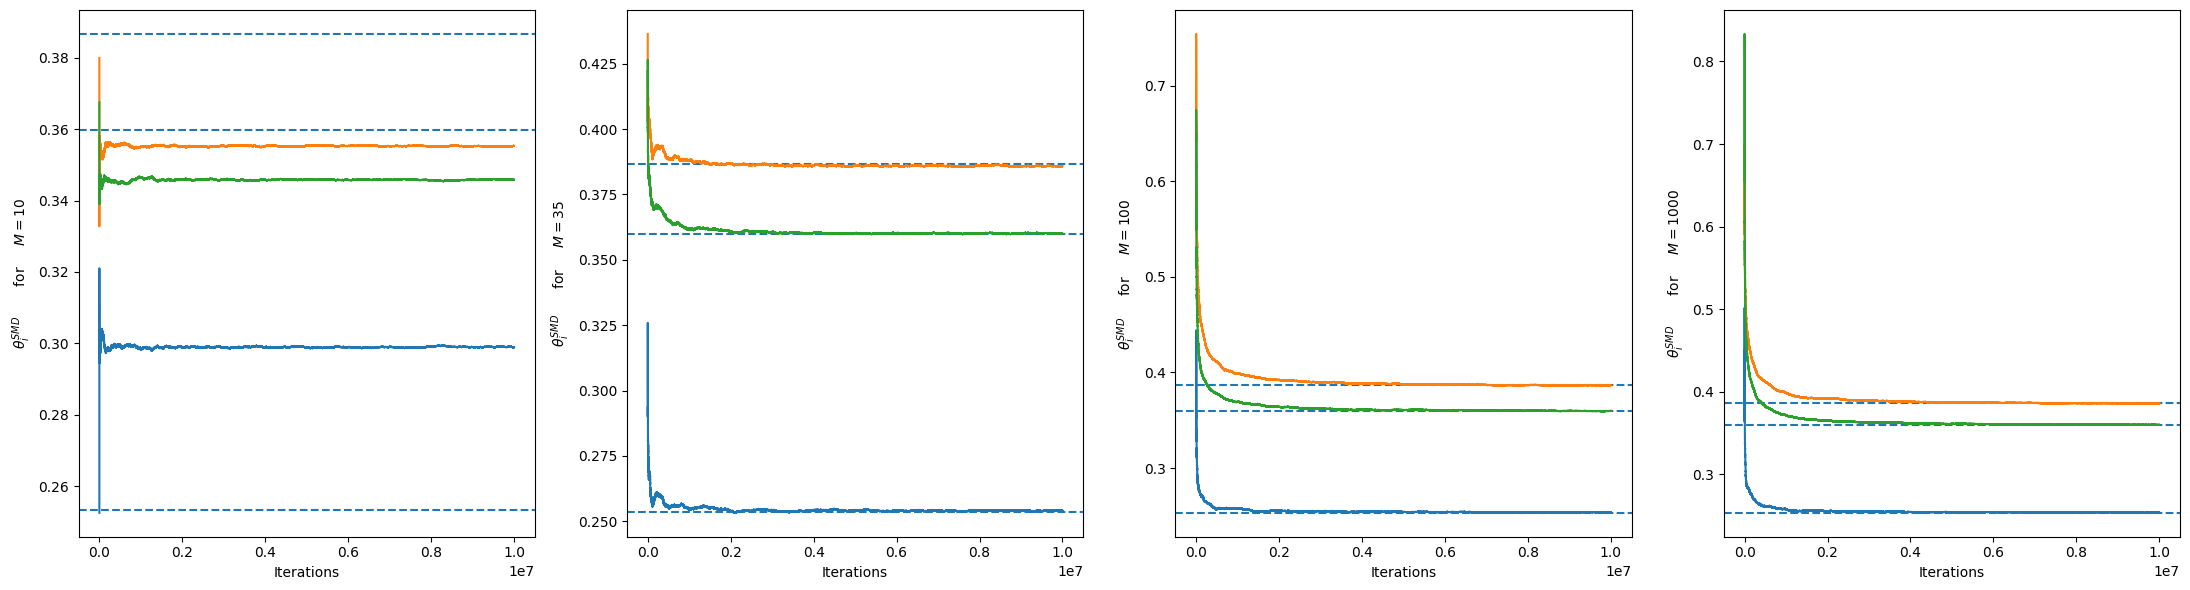

In [89]:
fig, axes= plt.subplots(1,4, figsize=(22,6))


for j in range(len(SM_theta)):
    axes[2].axhline(SM_theta[j], linestyle='--')
for i in range(problem1.nb_asset):
    axes[2].plot(problem1.ys[i] / sum(problem1.y), label=f'Component {i+1}')
    
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel(r'$\theta^{SMD}_i$     for     $M=100 $ ')


for j in range(len(SM_theta)):
    axes[1].axhline(SM_theta[j], linestyle='--')
for i in range(problem4.nb_asset):
    axes[1].plot(problem4.ys[i] / sum(problem4.y), label=f'Component {i+1}')
    
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel(r'$\theta^{SMD}_i$      for     $M=35$')


for j in range(len(SM_theta)):
    axes[0].axhline(SM_theta[j], linestyle='--')
for i in range(problem3.nb_asset):
    axes[0].plot(problem3.ys[i] / sum(problem3.y), label=f'Component {i+1}')
    
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel(r'$\theta^{SMD}_i$       for     $M=10 $')
 

for j in range(len(SM_theta)):
    axes[3].axhline(SM_theta[j], linestyle='--')
for i in range(problem5.nb_asset):
    axes[3].plot(problem5.ys[i] / sum(problem5.y), label=f'Component {i+1}')
    
axes[3].set_xlabel('Iterations')
axes[3].set_ylabel(r'$\theta^{SMD}_i$       for     $M=1000 $')
plt.tight_layout()
plt.show()


## Deterministic Case


In [10]:
M = 100
n_iter = 50000

In [11]:
sol1 = determ_sol(SM_model, M, n_iter, nb_asset,  budgets)

100%|██████████| 49999/49999 [05:04<00:00, 164.44it/s]


In [12]:
n_iter = 1000

In [13]:
sol2 = determ_sol(SM_model, M, n_iter, nb_asset,  budgets, fixed_stepsize=True)

100%|██████████| 999/999 [00:06<00:00, 163.08it/s]


In [14]:
n_iter = 10000
#n_iter = 2000000 in the paper we do it with this number of iterations, but be careful as it takes a lot of time

In [15]:
#this may take a lot of time, so be careful
sol3 = determ_sol(SM_model, M, n_iter, nb_asset,  budgets, exp = 0.75)

100%|██████████| 9999/9999 [01:01<00:00, 162.30it/s]


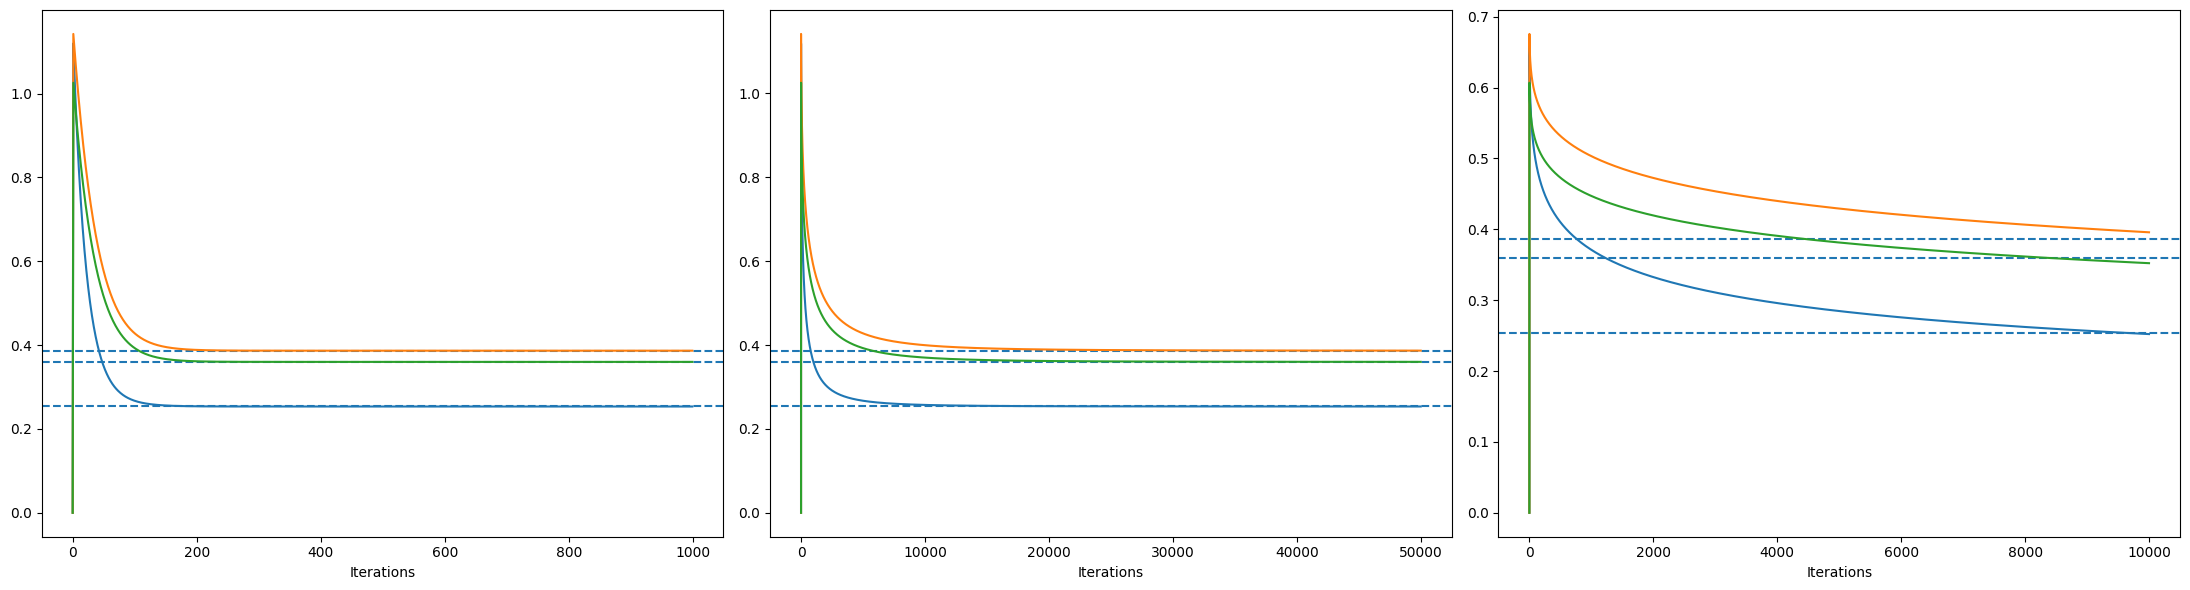

In [18]:
fig, axes= plt.subplots(1,3, figsize=(22,6))

for j in range(len(SM_theta)):
    axes[2].axhline(SM_theta[j], linestyle='--')
for i in range(sol3.nb_asset):
    axes[2].plot(sol3.ys[i] / sum(sol3.y), label=f'Component {i+1}')


for j in range(len(SM_theta)):
    axes[1].axhline(SM_theta[j], linestyle='--')
for i in range(sol1.nb_asset):
    axes[1].plot(sol1.ys[i] / sum(sol1.y), label=f'Component {i+1}')
    
for j in range(len(SM_theta)):
    axes[0].axhline(SM_theta[j], linestyle='--')
for i in range(sol2.nb_asset):
    axes[0].plot(sol2.ys[i] / sum(sol2.y), label=f'Component {i+1}')



axes[0].set_xlabel('Iterations')
axes[1].set_xlabel('Iterations')
axes[2].set_xlabel('Iterations')
plt.tight_layout()
plt.show()
